In [214]:
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from subprocess import check_output
from sklearn import model_selection, preprocessing
import sys
!{sys.executable} -m pip install xgboost 
#^Had issues with my pip installaion of xgboost through cmd 
color = sns.color_palette()
import warnings
warnings.filterwarnings("ignore")

# Data Exploration

In [183]:
df_train = pd.read_csv('train.csv')

In [184]:
df_train.shape # Shape of our training set

(30471, 292)

In [185]:
df_test=  pd.read_csv('test.csv')

In [236]:
id_test= df_test['id'] #Will need it later

In [186]:
df_test.shape #Shape of our test set

(7662, 291)

In [187]:
df_train.head(4).transpose()

,0,1,2,3
id,1,2,3,4
timestamp,2011-08-20,2011-08-23,2011-08-27,2011-09-01
full_sq,43,34,43,89
life_sq,27,19,29,50
floor,4,3,2,9
max_floor,NaN,NaN,NaN,NaN
material,NaN,NaN,NaN,NaN
build_year,NaN,NaN,NaN,NaN
num_room,NaN,NaN,NaN,NaN
kitch_sq,NaN,NaN,NaN,NaN


In [188]:
dataTypeDf = pd.DataFrame(df_train.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})

In [189]:
dataTypeDf  #Different types of datatypes used to describe various features & their count

,variableType,count
0,int64,157
1,float64,119
2,object,16


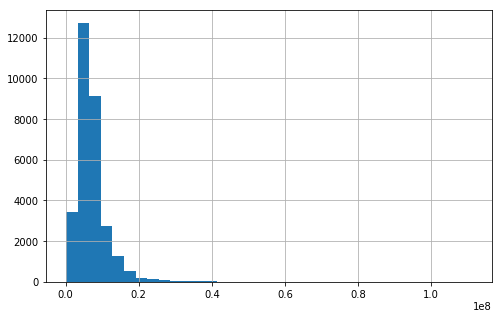

In [190]:
ax = df_train['price_doc'].hist(bins=35, figsize=(8,5)) #Distribution of our target variable

In [191]:
#Missing values expressed as %Missing for respective features 
missing_df = df_train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df['missing_count']=(missing_df['missing_count']/30471)*100
missing_df=missing_df.sort_values(by=['missing_count'], ascending=False)
missing_df=missing_df.set_index('column_name')
missing_df.head()

,missing_count
column_name,
hospital_beds_raion,47.392603
build_year,44.649011
state,44.498047
cafe_sum_500_max_price_avg,43.585704
cafe_sum_500_min_price_avg,43.585704


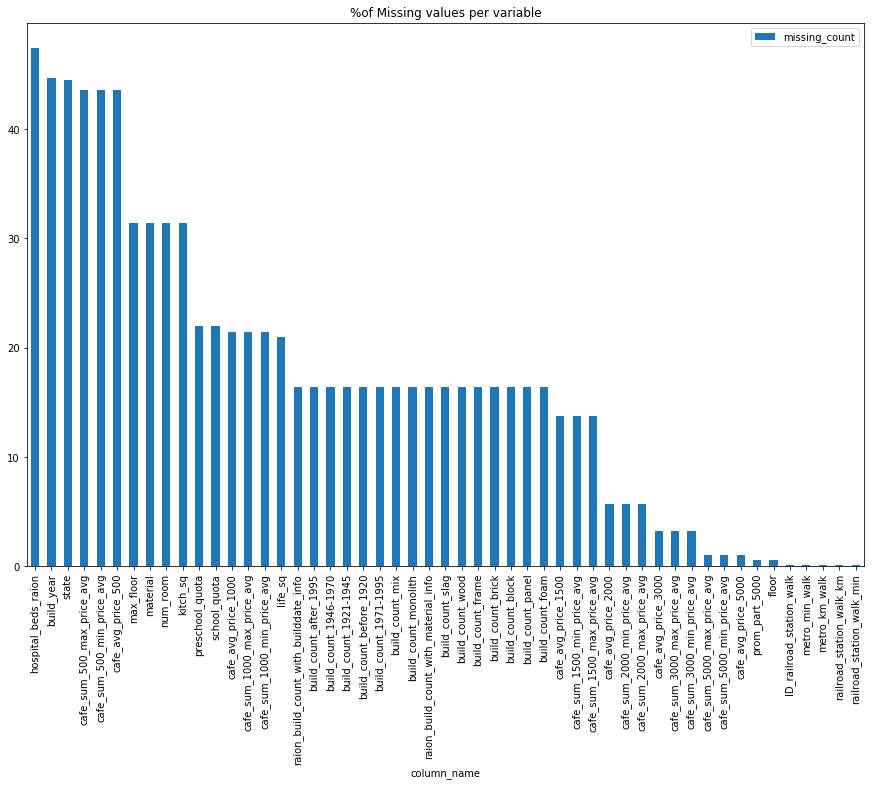

In [192]:
missing_df.plot.bar(fontsize=10, figsize=(15,10), title = "%of Missing values per variable")

In [193]:
df_train['timestamp'] = pd.to_datetime(df_train.timestamp) #Date time conversion

In [194]:
df_test['timestamp'] = pd.to_datetime(df_test.timestamp) #Date time conversion

In [195]:
df_train.iloc[0]['timestamp'] #First timestamp

Timestamp('2011-08-20 00:00:00')

In [196]:
df_train.iloc[-1]['timestamp']#Last timestamp

Timestamp('2015-06-30 00:00:00')

In [197]:
df_train.iloc[-1]['timestamp'] - df_train.iloc[0]['timestamp']# Span of our data

Timedelta('1410 days 00:00:00')

In [198]:
df_train['year'] = df_train['timestamp'].dt.year 
df_train['month'] = df_train['timestamp'].dt.month 
df_train['day'] = df_train['timestamp'].dt.day 
df_train['dayofweek'] = df_train['timestamp'].dt.dayofweek 

# Cleaning Data

### Converting Bad values, Outliers.... to NaN and delegating them to XgBoost to be dealt with for imputation internally

In [199]:
df_new=pd.concat([df_train,df_test]) #Combining our test & training examples 

In [200]:
bad_index = df_new[df_new.life_sq >= df_new.full_sq ].index
df_new.ix[bad_index, "life_sq"] = np.NaN
#Life_sq >= full_sq------Logical Error
bad_index = df_new[df_new.kitch_sq >= df_new.full_sq].index
df_new.ix[bad_index, "kitch_sq"] = np.NaN
#Full_sq < Kitch_sq------Logical Error
bad_index = df_new[df_new.life_sq < 10].index
df_new.ix[bad_index, "life_sq"] = np.NaN
#Life_sq < 10------Outlier
bad_index = df_new[df_new.full_sq < 10].index
df_new.ix[bad_index, "full_sq"] = np.NaN
#Life_sq < 10------Outlier
bad_index = df_new[df_new.kitch_sq >= df_new.life_sq].index
df_new.ix[bad_index, "kitch_sq"] = np.NaN
#Life_sq < Kitch_sq------Bad Value
bad_index = df_new[(df_new.kitch_sq == 0).values].index
df_new.ix[bad_index, "kitch_sq"] = np.NaN
#Kitch_sq is O---Bad-Value
bad_index = df_new[(df_new.life_sq == 0).values].index
df_new.ix[bad_index, "life_sq"] = np.NaN
#Life__sq is O---Bad-Value
bad_index = df_new[df_new.num_room == 0].index 
df_new.ix[bad_index, "num_room"] = np.NaN
#0 Rooms----Bad-Value
bad_index = df_new[df_new.max_floor == 0].index
df_new.ix[bad_index, "max_floor"] = np.NaN
#Max_floor is O---Bad-Value
bad_index = df_new[df_new.floor > df_new.max_floor].index
df_new.ix[bad_index, "max_floor"] = np.NaN
#New_floor > Max_floor------Logical Error

# Feature Engineering

In [201]:
#Label Encoding for categorical features
for i in df_new.columns:
    if df_new[i].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_new[i].values))
        df_new[i] = lbl.transform(list(df_new[i].values))

In [202]:
#Floor features
df_new['relative_floor'] = df_new.floor / df_new.max_floor
df_new['floor_to_top'] = df_new.max_floor - df_new.floor

#Room features
df_new['avg_room_size'] = (df_new.life_sq - df_new.kitch_sq) / df_new.num_room
df_new['life_sq_prop'] = df_new.life_sq / df_new.full_sq
df_new['kitch_sq_prop'] = df_new.kitch_sq / df_new.full_sq

#Datettime features
df_new['bought_minus_built'] = df_new['year'] - df_new['build_year']

month_year = (df_new.timestamp.dt.month + df_new.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_new['_month_year_cnt'] = month_year.map(month_year_cnt_map)
    
week_year = (df_new.timestamp.dt.weekofyear + df_new.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_new['_week_year_cnt'] = week_year.map(week_year_cnt_map)

#Density Features & Ratios
df_new['_pop_density'] = df_new.raion_popul / df_new.area_m
df_new['_hospital_bed_density'] = df_new.hospital_beds_raion / df_new.raion_popul
df_new['_healthcare_centers_density'] = df_new.healthcare_centers_raion / df_new.raion_popul
df_new['_shopping_centers_density'] = df_new.shopping_centers_raion / df_new.raion_popul
df_new['_university_top_20_density'] = df_new.university_top_20_raion / df_new.raion_popul
df_new['_sport_objects_density'] = df_new.sport_objects_raion / df_new.raion_popul
df_new['_good_bad_propotion'] = (df_new.sport_objects_raion + 1) / (df_new.additional_education_raion + 1)
df_new['_num_schools'] = df_new.sport_objects_raion + df_new.additional_education_raion
df_new['_schools_density'] = (df_new._num_schools + df_new.raion_popul)/df_new.raion_popul
df_new['_additional_education_density'] = df_new.additional_education_raion / df_new.raion_popul
df_new['_ratio_preschool'] = df_new.preschool_quota / df_new.children_preschool
df_new['_seat_per_preschool_center'] = df_new.preschool_quota / df_new.preschool_education_centers_raion
df_new['_ratio_school'] = df_new.school_quota / df_new.children_school
df_new['_seat_per_school_center'] = df_new.school_quota / df_new.school_education_centers_raion
df_new['_raion_top_20_school'] = df_new['school_education_centers_top_20_raion'] / df_new['school_education_centers_raion']
df_new['_female_ratio'] = df_new.female_f / df_new.full_all
df_new['_male_ratio'] = df_new.male_f / df_new.full_all
df_new['_male_female_ratio_area'] = df_new.male_f / df_new.female_f
df_new['_male_female_ratio_district'] = (df_new.young_male + df_new.work_male + df_new.ekder_male)/ (df_new.young_female + df_new.work_female + df_new.ekder_female)
df_new['_young_ratio'] = df_new.young_all / df_new.raion_popul
df_new['_young_female_ratio'] = df_new.young_female / df_new.raion_popul
df_new['_young_male_ratio'] = df_new.young_male / df_new.raion_popul
df_new['_work_ratio'] = df_new.work_all / df_new.raion_popul
df_new['_work_female_ratio'] = df_new.work_female / df_new.raion_popul
df_new['_work_male_ratio'] = df_new.work_male / df_new.raion_popul
df_new['_children_burden'] = df_new.young_all / df_new.work_all
df_new['_ekder_ratio'] = df_new.ekder_all / df_new.raion_popul
df_new['_ekder_female_ratio'] = df_new.ekder_female / df_new.raion_popul
df_new['_ekder_male_ratio'] = df_new.ekder_male / df_new.raion_popul
df_new['_congestion_metro'] = df_new.metro_km_avto / df_new.metro_min_avto
df_new['_congestion_metro'].fillna(df_new['_congestion_metro'].mean(), inplace=True) #Mean imputation

In [203]:
#inspecting our feature space after labelencoding and creation of new features
dataTypeDf = pd.DataFrame(df_new.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
dataTypeDf

,variableType,count
0,int64,173
1,float64,160
2,datetime64[ns],1


In [204]:
df_new.shape #Examining the dimensions of our data after feature engineering & cleaning

(38133, 334)

# Naive XGB to estimate feature importance & the subsequent correlation between important features

In [215]:
train_y = df_new.price_doc.values[:30471]
train_x = df_new.drop(["id", "timestamp", "price_doc"], axis=1)[:30471]
test_y = df_new.price_doc.values[30471:]
test_x= df_new.drop(["id", "timestamp", "price_doc"], axis=1)[30471:]

In [206]:
#Just a Naive XGB to get an idea for the most important features 
import xgboost as xgb
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_x, train_y, feature_names=train_x.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)


[23:46:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:46:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:46:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:46:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:46:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:46:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:46:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:46:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[23:46:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[23:46:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[23:46:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[23:46:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:46:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[23:46:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

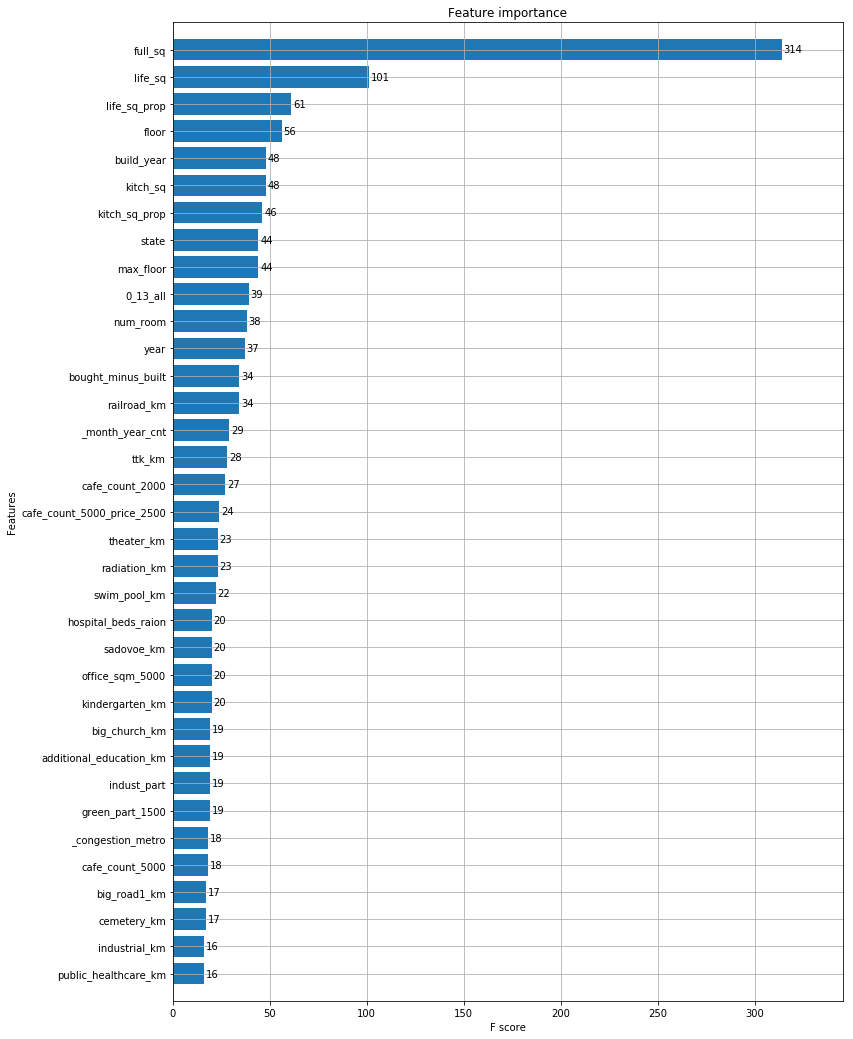

In [216]:
# Plot the feature importance 
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=35, height=0.8, ax=ax)
f_score=model.get_score(importance_type='weight')
f_score_converted = pd.DataFrame()
f_score_converted['features'] = f_score.keys()
f_score_converted['importance'] = f_score.values()
f_score_converted.sort_values(by=['importance'],ascending=False,inplace=True)

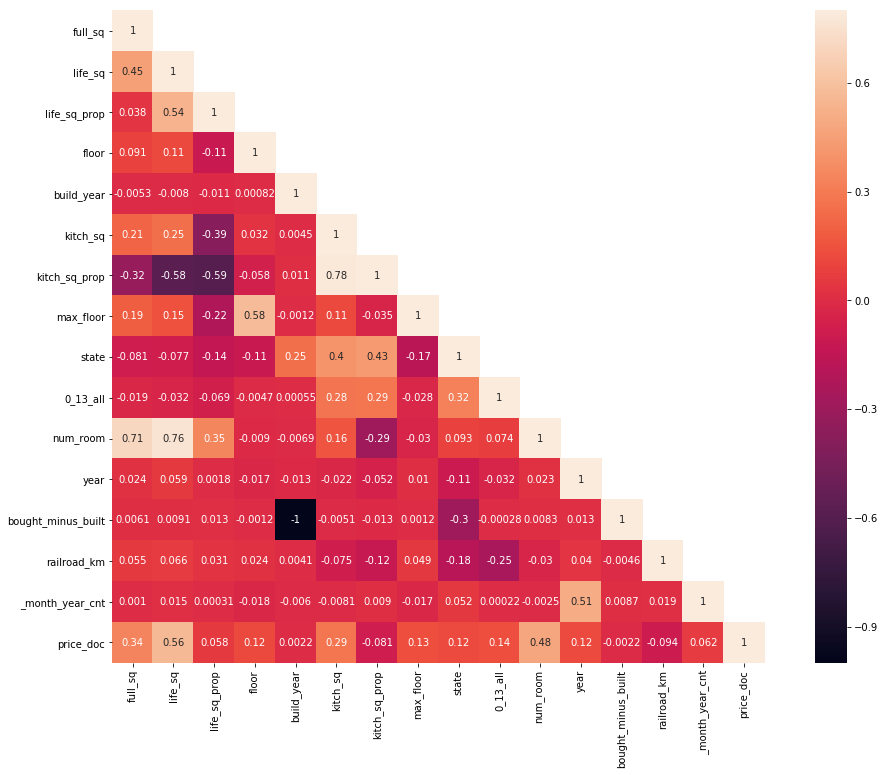

In [209]:
#Exploring the correlations between important features 
topFeatures = f_score_converted["features"].tolist()[:15]
topFeatures.append("price_doc")
corrMatt = df_new[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(18,12)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

# Tuning XGB (num_boost_rounds)

[0]	train-rmse:8.20523e+06	test-rmse:8.21017e+06
[50]	train-rmse:2.50755e+06	test-rmse:2.87986e+06
[100]	train-rmse:2.16736e+06	test-rmse:2.6952e+06
[150]	train-rmse:2.03188e+06	test-rmse:2.65264e+06
[200]	train-rmse:1.93468e+06	test-rmse:2.63074e+06
[250]	train-rmse:1.86202e+06	test-rmse:2.62061e+06
[300]	train-rmse:1.79671e+06	test-rmse:2.61155e+06
[350]	train-rmse:1.74414e+06	test-rmse:2.60658e+06
[400]	train-rmse:1.69069e+06	test-rmse:2.60282e+06
best num_boost_rounds =  384
[01:37:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[01:37:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[01:37:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[01:37:30] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[01:37:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[01:37:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[01:37:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[01:37:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[01:37:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[01:37:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[01:37:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[01:37:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[01:37:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[01:37:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[01:37:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[01:37:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[01:37:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[01:37:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[01:38:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[01:38:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[01:38:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[01:38:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[01:38:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[01:38:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[01:38:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[01:38:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[01:38:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[01:38:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[01:38:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[01:38:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[01:38:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[01:38:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[01:38:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[01:38:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[01:38:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[01:38:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[01:38:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[01:38:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[01:38:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

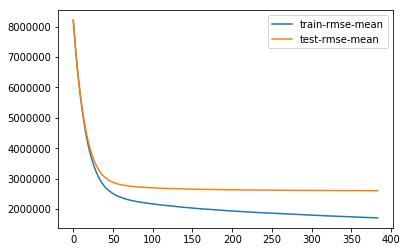

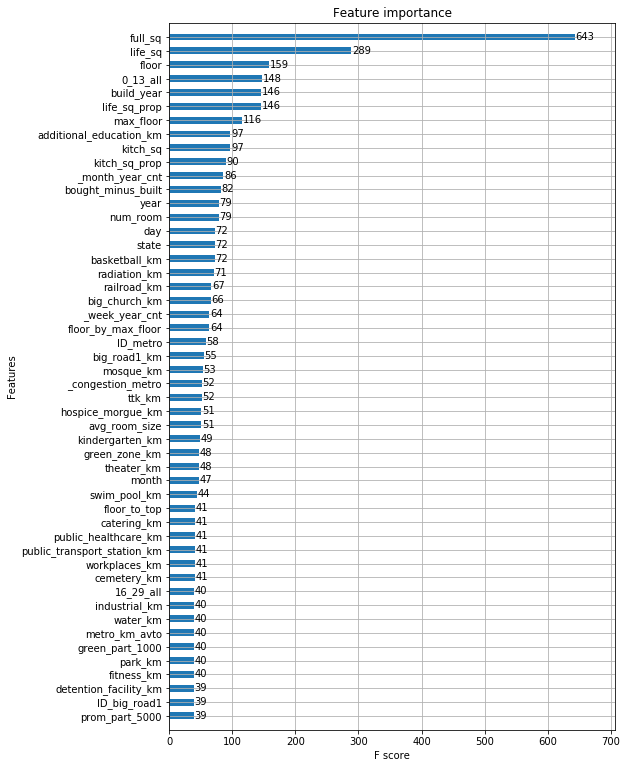

In [223]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_x, train_y, feature_names=train_x.columns.values)
dtest = xgb.DMatrix(test_x, feature_names=train_x.columns.values)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
verbose_eval=50, show_stdv=False)
num_boost_rounds = len(cv_output)
print('best num_boost_rounds = ', len(cv_output))
#best num_boost_rounds =  384 Check the underneath output to confirm
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=384)
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)



# Grid Serching to optimize max_depth & colsample_bytree using rmse as eval metric

**Note: If you want to execute this locally it might be fairly time consuming**

**~40 min for 3 fold CV on my system**

**Refer documentation for tuned hyperparameters or look for xgb_GridSearch.txt in the repo**

In [242]:

GSparams = {'max_depth':[4,5,6], 'colsample_bytree':[0.6,0.8,1]} # grid search params
params = {'eta': 0.05, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8, 'silent':1,
          'min_child_weight': 1, 'gamma': 0, 'objective': 'reg:linear', 'eval_metric': 'rmse'} # default params
gs = '' # str to store GridSearch result
items = sorted(GSparams.items())
for i in items[0][1]:
    for j in items[1][1]:
        params[items[0][0]] = i
        params[items[1][0]] = j
        xgbcv = xgb.cv(params, dtrain, 384, nfold = 3, early_stopping_rounds = 20)
        gs = ('test_score:%.4f, train_score:%.4f, best_round:%d, %s:%f, %s:%f \n'
        %(xgbcv.iloc[-1,0], xgbcv.iloc[-1,2], xgbcv.shape[0], items[0][0], i, items[1][0], j))
        f = open('xgb_GridSearch.log', mode = 'a')
        f.write(gs)
        f.close()

#BEST CV performace for the following parameters: max_depth:[6] 'colsample_bytree':0.8

In [246]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_x, train_y, feature_names=train_x.columns.values)
dtest = xgb.DMatrix(test_x, feature_names=train_x.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=384)


[03:18:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[03:18:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[03:18:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[03:18:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[03:18:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[03:18:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[03:18:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[03:18:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[03:18:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[03:18:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[03:18:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[03:18:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[03:18:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[03:18:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning

In [247]:
y_predict = model.predict(dtest)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output

,id,price_doc
0,30474,4976762.50
1,30475,7650987.50
2,30476,5228023.50
3,30477,5451080.00
4,30478,4560522.50
5,30479,7479784.00
6,30480,4201390.50
7,30481,3870922.00
8,30482,4477676.50
9,30483,4336474.50
